In [1]:
%matplotlib inline

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

In [2]:
dataset = nc.Dataset("lut_optical_properties_M7.nc")

In [3]:
dataset.variables['sigma_1'].dimensions

('dis', 'ni', 'nr')

In [4]:
# dependent variables: AE (from sigma at different sizes/wavelengths/refr ind) and MEC (from sigma at one size/wavelength/refr ind & density)
# additionally there may be a second mode

# Purpose: contour indepedent variables in AE/MEC plot

# Strategy: 
# 1) create grid with independent variables
# 2) Calculate AE and MEC
# 3) Regularize AE/MEC grid and interpolate independent variables

In [5]:
# Below ranges come from Boucher's code that was used to generate ECHAM-HAM LUTs
dis_1_min = 0.001
dis_1_max = 25.
m_dis_1   = 101
ni_1_min  = 1.e-9
ni_1_max  = 1.00
m_ni_1    = 201
nr_1_min  = 1.33
nr_1_max  = 2.00
m_nr_1    = 101

dis_2_min = 0.4
dis_2_max = 40.
m_dis_2   = 101
ni_2_min  = 1.e-9
ni_2_max  = 1.00
m_ni_2    = 201
nr_2_min  = 1.33
nr_2_max  = 2.00
m_nr_2    = 101

# diss = 2 pi r_m/lamba, where r_m is the mean geometric radius (Grainger doc)
diss_1 = np.logspace(np.log10(dis_1_min), np.log10(dis_1_max),m_dis_1,endpoint=True)
nis_1  = np.logspace(np.log10(ni_1_min),np.log10(ni_1_max),m_ni_1,endpoint=True)
nrs_1  = np.linspace(nr_1_min,nr_1_max,m_nr_1,endpoint=True)

diss_2 = np.logspace(np.log10(dis_2_min), np.log10(dis_2_max),m_dis_2,endpoint=True)
nis_2  = np.logspace(np.log10(ni_2_min),np.log10(ni_2_max),m_ni_2,endpoint=True)
nrs_2  = np.linspace(nr_2_min,nr_2_max,m_nr_2,endpoint=True)



def compareLUT(rm, ni, nr):
    
    sigma_a1 = RetrieveFromLUT(2.*np.pi*rm/0.44, ni, nr, 'sigma_1')*0.44**2
    sigma_a2 = RetrieveFromLUT(2.*np.pi*rm/0.55, ni, nr, 'sigma_1')*0.55**2
    sigma_a3 = RetrieveFromLUT(2.*np.pi*rm/0.86, ni, nr, 'sigma_1')*0.86**2
    sigma_b1 = RetrieveFromLUT(2.*np.pi*rm/0.44, ni, nr, 'sigma_2')*0.44**2
    sigma_b2 = RetrieveFromLUT(2.*np.pi*rm/0.55, ni, nr, 'sigma_2')*0.55**2
    sigma_b3 = RetrieveFromLUT(2.*np.pi*rm/0.86, ni, nr, 'sigma_2')*0.86**2

    print("Extinctions from LUT1 and LUT2 are {:4.2f} and {:4.2f}".format(sigma_a2,sigma_b2))
    print("AEs from LUT1 and LUT2 are {:4.2f} and {:4.2f}".format(-np.log10(sigma_a1/sigma_a3)/np.log10(0.44/0.86),-np.log10(sigma_b1/sigma_b3)/np.log10(0.44/0.86)))
    return
    
    
def RetrieveSigma(rm, wavel, ni, nr, LUTvar): 
    
    sigma = RetrieveFromLUT(2.*np.pi*rm/wavel, ni, nr, LUTvar)*wavel**2*1.e-12
    
    return sigma # [m2]
    
def calcAE(sigma_a, wavel_a, sigma_b, wavel_b):
    
    AE = -np.log10(sigma_a/sigma_b)/np.log10(wavel_a/wavel_b)
    
    return AE

def RetrieveMass(rm, dens, LUTvar):

    if LUTvar == 'sigma_1': # take into account units of Rm [mum] and dens [kg/m3] as well as size distribution
        mass  = 4.0/3.0*np.pi*rm**3*np.exp(9./2.*np.log(1.59)**2)*1.e-18*dens # [kg]
    if LUTvar == 'sigma_2':
        mass  = 4.0/3.0*np.pi*rm**3*np.exp(9./2.*np.log(2.00)**2)*1.e-18*dens # [kg]

    return mass # [kg]

def RetrieveCrossSection(rm, LUTvar):

    # rm is mean geometric size    
    if LUTvar == 'sigma_1': # take into account units of Rm [mum] as well as size distribution
        crosssection  = np.pi*rm**2*np.exp(2.*np.log(1.59)**2)*1.e-12 # [m2]
    if LUTvar == 'sigma_2':
        crosssection  = np.pi*rm**2*np.exp(2.*np.log(2.00)**2)*1.e-12 # [m2]

    return crosssection # [m2]


def calcMEC(sigma, mass):
     
    return sigma/mass # [m2/kg]


def calcReff(Rm_1,Rm_2,mode): # checked vs Grainger on 202022/02/23
    
    # Rm is mean geometric radius, and Reff is effective particle size
    mom2 = Rm_1**2*np.exp(2.*np.log(1.59)**2)*(1.-mode)+Rm_2**2*np.exp(2.*np.log(2.00)**2)*mode
    mom3 = Rm_1**3*np.exp(9./2.*np.log(1.59)**2)*(1.-mode)+Rm_2**3*np.exp(9./2.*np.log(2.00)**2)*mode

    return mom3/mom2

def RetrieveFromLUT(dis, ni, nr, LUTvar):
    
    # Simple retrieval scheme based on NN
    if LUTvar == 'sigma_1':
        idis = (m_dis_1-1)*np.log10(dis/dis_1_min)/np.log10(dis_1_max/dis_1_min)
        ini  = (m_ni_1-1)*np.log10(ni/ni_1_min)/np.log10(ni_1_max/ni_1_min)
        inr  = (m_nr_1-1)*(nr-nr_1_min)/(nr_1_max-nr_1_min)
    
        if (idis < 0 or idis > m_dis_1-1):
            print("[ERROR] from RetrieveFromLut: idis {} out of range.".format(idis))
        if (ini < 0 or ini > m_ni_1-1):
            print("[ERROR] from RetrieveFromLut: ini {} out of range.".format(ini))    
        if (inr < 0 or inr > m_nr_1-1):
            print("[ERROR] from RetrieveFromLut: inr {} out of range.".format(inr))
        
    if LUTvar == 'sigma_2':
        idis = np.round( (m_dis_2-1)*np.log10(dis/dis_2_min)/np.log10(dis_2_max/dis_2_min) )
        ini  = np.round( (m_ni_2-1)*np.log10(ni/ni_2_min)/np.log10(ni_2_max/ni_2_min) )
        inr  = np.round( (m_nr_2-1)*(nr-nr_2_min)/(nr_2_max-nr_2_min) )
    
        if (idis < 0 or idis > m_dis_2-1):
            print("[ERROR] from RetrieveFromLut: idis {} out of range.".format(idis))
        if (ini < 0 or ini > m_ni_2-1):
            print("[ERROR] from RetrieveFromLut: ini {} out of range.".format(ini))    
        if (inr < 0 or inr > m_nr_2-1):
            print("[ERROR] from RetrieveFromLut: inr {} out of range.".format(inr))
            
    LUT = dataset.variables[LUTvar]
    
# Need more sophisticated interpolation routines
    retrieved = LUT[np.round(idis), np.round(ini), np.round(inr)] 
    
    return retrieved


In [6]:
compareLUT(.1, 1.e-9, 1.5)

Extinctions from LUT1 and LUT2 are 0.09 and 0.20
AEs from LUT1 and LUT2 are 2.00 and 0.69


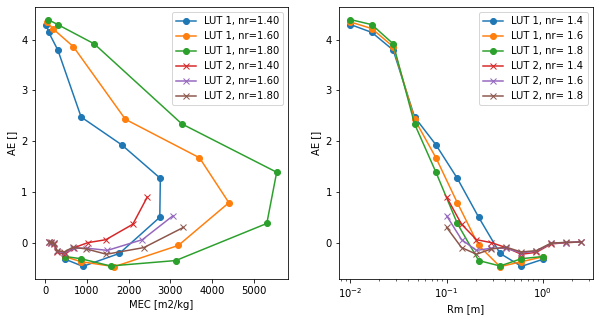

In [7]:
# Here we explore variation in Reff for different nr and LUT 

# ECHAM-HAM
# SO4:    1841 kg/m3
# OC, BC: 2000 kg/m3
# SS:     2165 kg/m3
# DU:     2650 kg/m3

# Constants:
ni   = 1.e-9
nrs  = [1.4,1.6,1.8]
dens = 2000.0   # [kg/m3]  
wavel   = 0.550 # [mum] 
wavel_a = 0.440 # [mum] 
wavel_b = 0.860 # [mum] 

fig, axs = plt.subplots(1,2,figsize=(10,5))

# LUT 2
m_Rm = 10
Rm_a = 0.01  # [mum]
Rm_b = 1. # [mum]

Rms = np.logspace(np.log10(Rm_a),np.log10(Rm_b), m_Rm , endpoint=True)
AEs   = np.zeros(m_Rm)
MECs  = np.zeros(m_Rm)

for nr in nrs:
    for i in range(m_Rm):
        sigma   = RetrieveSigma(Rms[i], wavel  , ni, nr, 'sigma_1')
        sigma_a = RetrieveSigma(Rms[i], wavel_a, ni, nr, 'sigma_1')
        sigma_b = RetrieveSigma(Rms[i], wavel_b, ni, nr, 'sigma_1')
        mass    = RetrieveMass(Rms[i], dens, 'sigma_1')
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)
    
    axs[0].plot(MECs,AEs,label='LUT 1, nr={:4.2f}'.format(nr),marker='o')
    axs[1].plot(Rms,AEs,label='LUT 1, nr={:4.2g}'.format(nr),marker='o')
    
# LUT 2
m_Rm = 10
Rm_a = 0.1  # [mum]
Rm_b = 2.5 # [mum]

Rms = np.logspace(np.log10(Rm_a),np.log10(Rm_b), m_Rm , endpoint=True)
AEs   = np.zeros(m_Rm)
MECs  = np.zeros(m_Rm)

for nr in nrs:
    for i in range(m_Rm):
        sigma   = RetrieveSigma(Rms[i], wavel  , ni, nr, 'sigma_2')
        sigma_a = RetrieveSigma(Rms[i], wavel_a, ni, nr, 'sigma_2')
        sigma_b = RetrieveSigma(Rms[i], wavel_b, ni, nr, 'sigma_2')
        mass    = RetrieveMass(Rms[i], dens, 'sigma_2')
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)
    
    axs[0].plot(MECs,AEs,label='LUT 2, nr={:4.2f}'.format(nr),marker='x')
    axs[1].plot(Rms,AEs,label='LUT 2, nr={:4.2g}'.format(nr),marker='x')

axs[1].set_xscale('log')    
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('MEC [m2/kg]')
axs[0].set_ylabel('AE []')
axs[1].set_xlabel('Rm [m]')
axs[1].set_ylabel('AE []')
plt.show()

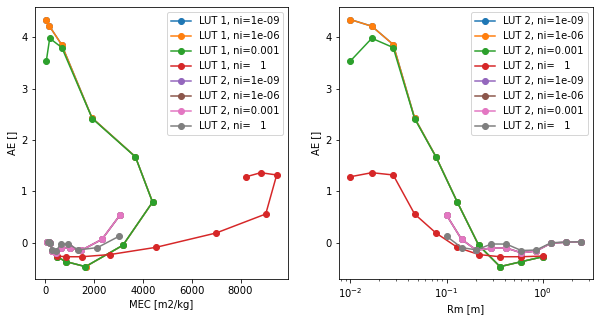

In [8]:
# Here we explore variation in Reff for different ni and LUT 

# ECHAM-HAM
# SO4:    1841 kg/m3
# OC, BC: 2000 kg/m3
# SS:     2165 kg/m3
# DU:     2650 kg/m3

# Constants:
nis  = [1.e-9, 1.e-6, 1.e-3, 1]
nr  = 1.6
dens = 2000.0   # [kg/m3]
wavel   = 0.550 # [mum] 
wavel_a = 0.440 # [mum] 
wavel_b = 0.860 # [mum] 

fig, axs = plt.subplots(1,2,figsize=(10,5))

# LUT 1
m_Rm = 10
Rm_a = 0.01  # [mum]
Rm_b = 1. # [mum]

Rms = np.logspace(np.log10(Rm_a),np.log10(Rm_b), m_Rm , endpoint=True)
AEs   = np.zeros(m_Rm)
MECs  = np.zeros(m_Rm)
Reffs = np.zeros(m_Rm)

for ni in nis:
    for i in range(m_Rm):
        sigma   = RetrieveSigma(Rms[i], wavel  , ni, nr, 'sigma_1')
        sigma_a = RetrieveSigma(Rms[i], wavel_a, ni, nr, 'sigma_1')
        sigma_b = RetrieveSigma(Rms[i], wavel_b, ni, nr, 'sigma_1')
        mass    = RetrieveMass(Rms[i], dens, 'sigma_1')
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)

    
    axs[0].plot(MECs,AEs,label='LUT 1, ni={:4.2g}'.format(ni),marker='o')
    axs[1].plot(Rms,AEs,label='LUT 2, ni={:4.2g}'.format(ni),marker='o')
    
# LUT 2
m_Rm = 10
Rm_a = 0.1  # [mum]
Rm_b = 2.5 # [mum]

Rms = np.logspace(np.log10(Rm_a),np.log10(Rm_b), m_Rm , endpoint=True)
AEs   = np.zeros(m_Rm)
MECs  = np.zeros(m_Rm)

for ni in nis:
    for i in range(m_Rm):
        sigma   = RetrieveSigma(Rms[i], wavel  , ni, nr, 'sigma_2')
        sigma_a = RetrieveSigma(Rms[i], wavel_a, ni, nr, 'sigma_2')
        sigma_b = RetrieveSigma(Rms[i], wavel_b, ni, nr, 'sigma_2')
        mass    = RetrieveMass(Rms[i], dens, 'sigma_2')
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)

    
    axs[0].plot(MECs,AEs,label='LUT 2, ni={:4.2g}'.format(ni),marker='o')
    axs[1].plot(Rms,AEs,label='LUT 2, ni={:4.2g}'.format(ni),marker='o')
    
axs[1].set_xscale('log')    
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('MEC [m2/kg]')
axs[0].set_ylabel('AE []')
axs[1].set_xlabel('Rm [m]')
axs[1].set_ylabel('AE []')
plt.show()

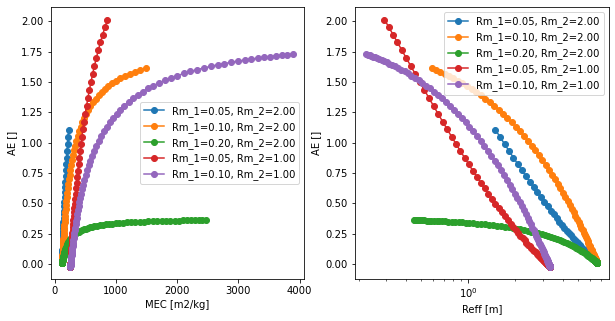

In [9]:
# Here we explore variation in mode contribution 

# ECHAM-HAM
# SO4:    1841 kg/m3
# OC, BC: 2000 kg/m3
# SS:     2165 kg/m3
# DU:     2650 kg/m3

# Constants:
ni  = 1.e-6
nr  = 1.6
dens = 2000.0  #  
wavel   = 0.550 # [mum] 
wavel_a = 0.440 # [mum] 
wavel_b = 0.860 # [mum] 

fig, axs = plt.subplots(1,2,figsize=(10,5))

# LUT 1
m_mode = 100

mode = np.logspace(-4,0.,m_mode,endpoint=True)

AEs   = np.zeros(m_mode)
MECs  = np.zeros(m_mode)
Reffs = np.zeros(m_mode)

#
Rm_1 = 0.05  # [mum]
Rm_2 = 2. # [mum]

for i in range(m_mode):
    
        sigma   = RetrieveSigma(Rm_1, wavel  , ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel  , ni, nr, 'sigma_2')*mode[i]
        sigma_a = RetrieveSigma(Rm_1, wavel_a, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_a, ni, nr, 'sigma_2')*mode[i]
        sigma_b = RetrieveSigma(Rm_1, wavel_b, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_b, ni, nr, 'sigma_2')*mode[i]
        mass    = RetrieveMass(Rm_1, dens, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveMass(Rm_2, dens, 'sigma_2')*mode[i] 
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)
        Reffs[i]= calcReff(Rm_1, Rm_2, mode[i])
   
axs[0].plot(MECs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')
axs[1].plot(Reffs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')
 
#
Rm_1 = 0.1  # [mum]
Rm_2 = 2. # [mum]

for i in range(m_mode):
    
        sigma   = RetrieveSigma(Rm_1, wavel  , ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel  , ni, nr, 'sigma_2')*mode[i]
        sigma_a = RetrieveSigma(Rm_1, wavel_a, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_a, ni, nr, 'sigma_2')*mode[i]
        sigma_b = RetrieveSigma(Rm_1, wavel_b, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_b, ni, nr, 'sigma_2')*mode[i]
        mass    = RetrieveMass(Rm_1, dens, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveMass(Rm_2, dens, 'sigma_2')*mode[i] 
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)
        Reffs[i]= calcReff(Rm_1, Rm_2, mode[i])
   
axs[0].plot(MECs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')
axs[1].plot(Reffs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')

#
Rm_1 = 0.2  # [mum]
Rm_2 = 2. # [mum]

for i in range(m_mode):
    
        sigma   = RetrieveSigma(Rm_1, wavel  , ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel  , ni, nr, 'sigma_2')*mode[i]
        sigma_a = RetrieveSigma(Rm_1, wavel_a, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_a, ni, nr, 'sigma_2')*mode[i]
        sigma_b = RetrieveSigma(Rm_1, wavel_b, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_b, ni, nr, 'sigma_2')*mode[i]
        mass    = RetrieveMass(Rm_1, dens, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveMass(Rm_2, dens, 'sigma_2')*mode[i] 
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)
        Reffs[i]= calcReff(Rm_1, Rm_2, mode[i])
   
axs[0].plot(MECs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')
axs[1].plot(Reffs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')


#
Rm_1 = 0.05  # [mum]
Rm_2 = 1. # [mum]

for i in range(m_mode):
    
        sigma   = RetrieveSigma(Rm_1, wavel  , ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel  , ni, nr, 'sigma_2')*mode[i]
        sigma_a = RetrieveSigma(Rm_1, wavel_a, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_a, ni, nr, 'sigma_2')*mode[i]
        sigma_b = RetrieveSigma(Rm_1, wavel_b, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_b, ni, nr, 'sigma_2')*mode[i]
        mass    = RetrieveMass(Rm_1, dens, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveMass(Rm_2, dens, 'sigma_2')*mode[i] 
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)
        Reffs[i]= calcReff(Rm_1, Rm_2, mode[i])
   
axs[0].plot(MECs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')
axs[1].plot(Reffs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')


#
Rm_1 = 0.1  # [mum]
Rm_2 = 1. # [mum]

for i in range(m_mode):
    
        sigma   = RetrieveSigma(Rm_1, wavel  , ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel  , ni, nr, 'sigma_2')*mode[i]
        sigma_a = RetrieveSigma(Rm_1, wavel_a, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_a, ni, nr, 'sigma_2')*mode[i]
        sigma_b = RetrieveSigma(Rm_1, wavel_b, ni, nr, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveSigma(Rm_2, wavel_b, ni, nr, 'sigma_2')*mode[i]
        mass    = RetrieveMass(Rm_1, dens, 'sigma_1')*(1.-mode[i]) + \
                  RetrieveMass(Rm_2, dens, 'sigma_2')*mode[i] 
        AEs[i]  = calcAE(sigma_a, wavel_a, sigma_b, wavel_b)
        MECs[i] = calcMEC(sigma, mass)
        Reffs[i]= calcReff(Rm_1, Rm_2, mode[i])
   
axs[0].plot(MECs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')
axs[1].plot(Reffs,AEs,label='Rm_1={:4.2f}, Rm_2={:4.2f}'.format(Rm_1,Rm_2),marker='o')


axs[1].set_xscale('log')
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('MEC [m2/kg]')
axs[0].set_ylabel('AE []')
axs[1].set_xlabel('Reff [m]')
axs[1].set_ylabel('AE []')
plt.show()

Text(0.5, 1.0, 'LUT 2')

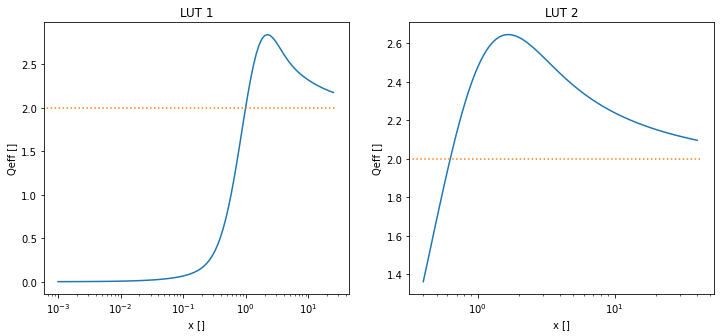

In [12]:
# Verify units of extinction by plotting efficiency

wavel = 0.55
Qeff_1 = np.zeros((diss_1.size,4))
Qeff_2 = np.zeros((diss_2.size,4))
nr=1.68400
ni=0.21290
for idiss,diss in enumerate(diss_1):    
    Qeff_1[idiss,0] = RetrieveSigma(wavel*diss_1[idiss]/2/np.pi, wavel, ni, nr, 'sigma_1')/ \
                      RetrieveCrossSection(wavel*diss_1[idiss]/2/np.pi, 'sigma_1')
    Qeff_1[idiss,1] = RetrieveSigma(wavel*diss_1[idiss]/2/np.pi, wavel, nis_1[0], nrs_1[-2], 'sigma_1')/ \
                      RetrieveCrossSection(wavel*diss_1[idiss]/2/np.pi, 'sigma_1')
    Qeff_1[idiss,2] = RetrieveSigma(wavel*diss_1[idiss]/2/np.pi, wavel, nis_1[-2], nrs_1[0], 'sigma_1')/ \
                      RetrieveCrossSection(wavel*diss_1[idiss]/2/np.pi, 'sigma_1')
    Qeff_1[idiss,3] = RetrieveSigma(wavel*diss_1[idiss]/2/np.pi, wavel, nis_1[-2], nrs_1[-2], 'sigma_1')/ \
                      RetrieveCrossSection(wavel*diss_1[idiss]/2/np.pi, 'sigma_1')

for idiss,diss in enumerate(diss_2):    
    Qeff_2[idiss,0] = RetrieveSigma(wavel*diss_2[idiss]/2/np.pi, wavel, ni, nr, 'sigma_2')/ \
                      RetrieveCrossSection(wavel*diss_2[idiss]/2/np.pi, 'sigma_2')
    Qeff_2[idiss,1] = RetrieveSigma(wavel*diss_2[idiss]/2/np.pi, wavel, nis_2[0], nrs_2[-2], 'sigma_2')/ \
                      RetrieveCrossSection(wavel*diss_2[idiss]/2/np.pi, 'sigma_2')
    Qeff_2[idiss,2] = RetrieveSigma(wavel*diss_2[idiss]/2/np.pi, wavel, nis_2[-2], nrs_2[0], 'sigma_2')/ \
                      RetrieveCrossSection(wavel*diss_2[idiss]/2/np.pi, 'sigma_2')
    Qeff_2[idiss,3] = RetrieveSigma(wavel*diss_2[idiss]/2/np.pi, wavel, nis_2[-2], nrs_2[-2], 'sigma_2')/ \
                      RetrieveCrossSection(wavel*diss_2[idiss]/2/np.pi, 'sigma_2')



    
fig, axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(diss_1,Qeff_1[:,0])
#axs[0].plot(diss_1,Qeff_1[:,1])
#axs[0].plot(diss_1,Qeff_1[:,2])
#axs[0].plot(diss_1,Qeff_1[:,3])
axs[0].plot(axs[0].get_xlim(),[2,2],':')
axs[0].set_xscale('log')

axs[1].plot(diss_2,Qeff_2[:,0])
#axs[1].plot(diss_2,Qeff_2[:,1])
#axs[1].plot(diss_2,Qeff_2[:,2])
#axs[1].plot(diss_2,Qeff_2[:,3])
axs[1].plot(axs[1].get_xlim(),[2,2],':')
axs[1].set_xscale('log')

axs[0].set_xlabel('x []')
axs[0].set_ylabel('Qeff []')
axs[0].set_title('LUT 1')
axs[1].set_xlabel('x []')
axs[1].set_ylabel('Qeff []')
axs[1].set_title('LUT 2')

In [11]:
for attr in dataset.ncattrs(): 
    print(attr, '=', getattr(dataset, attr))

authors = Philip Stier, Caltech (philip.stier@caltech.edu); Olivier Boucher, UK Met Office
history = NetCDF created by Philip Stier 06/2006
institution = California Institute of Technology
